# Анализ игрового рынка

# Введение

В нашем распоряжении данные по играм, их продажам в разных регионах, рейтингам критиков и игроков. В ходе работы произведем оценку данных, посмотрим как развивался рынок с 1980х годов прошлого века, оценим жизненный цикл платформ, определим влияние оценок на продажи среди популярных платформ последних лет, а также оценим разницу в поведении игроков в разных регионах. 
<br>Описание данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import re
sns.set_style('dark')

# Подготовка данных

## Оценка данных

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Нужно будет изменить название колонок - привести их к нижнему регистру.

In [6]:
df.columns = df.columns.str.lower()

Данные по продажам без пропусков. Есть пропуски в названии и жанре - посмотрим на них отдельно.

In [7]:
df.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропущены названия, жанр, оценки и рейтинг. Мы не сможем оценить влияние этих факторов на продажи, и сама платформа достаточно старая. Эти строки не исказят анализ, можно их удалить.

In [8]:
df = df.dropna(subset=['name'])

Оценка пользователей представлена как строка, потому, что есть значения <b>'tbd'</b> - по всей видимости игра не успела набрать необходимое количество оценок от пользователей чтобы рассчитать среднюю оценку. Для нас это равносильно отсутсвию значения, поэтому заменим <b>'tbd'</b> на NaN и приведем всю колонку к типу 'float'.

In [9]:
df.user_score = df.user_score.apply(lambda x: float(x) if x != 'tbd' else np.nan)

## Заполнение пропусков

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


У некоторых игр в названиях присутсвует год, но отсутсвует в колонке с датой релиза. Возьмем такие игры и заполним пропуски из названия.

In [11]:
year_dict = {}
for i in range(17):
    if i // 10 == 0:
        year_dict[str(0) + str(i)] = int(str(200) + str(i))
    else:
        year_dict[str(i)] = int(str(20) + str(i))
for i in range(80, 100):
    year_dict[str(i)] = int(str(19) + str(i))

def release_year(row):
    try:
        str_year = re.search(r'[0189]\d($|\s)', row['name']).group(0)
        row.year_of_release = year_dict[str_year]
    except:
        pass
    return row

In [12]:
df = df.apply(release_year, axis=1)

Среди оценок критиков и игроков много пропусков. Я не считаю, что заполнение пропусков разумно. На графиках ниже видно как исказятся данные при заполнении пропусков в оценках средним. Имеющихся данных достаточно, чтобы произвести анализ.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16466 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


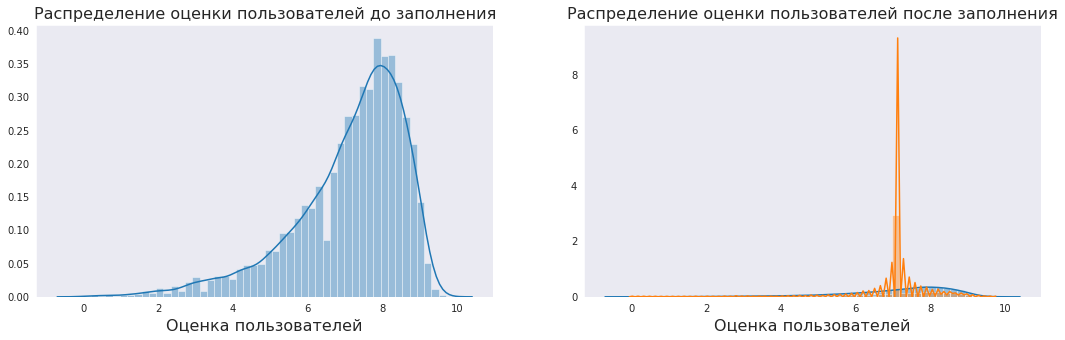

In [14]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(121)
ax1 = sns.distplot(df.user_score[df.user_score.notnull()])
ax1.set_xlabel('Оценка пользователей', fontdict={'fontsize': 16})
ax1.set_title('Распределение оценки пользователей до заполнения', fontdict={'fontsize': 16})
ax2 = plt.subplot(122)
ax2 = sns.distplot(df.user_score[df.user_score.notnull()])
ax2 = sns.distplot(df.user_score.fillna(df.user_score.mean()))
ax2.set_xlabel('Оценка пользователей', fontdict={'fontsize': 16})
ax2.set_title('Распределение оценки пользователей после заполнения', fontdict={'fontsize': 16});

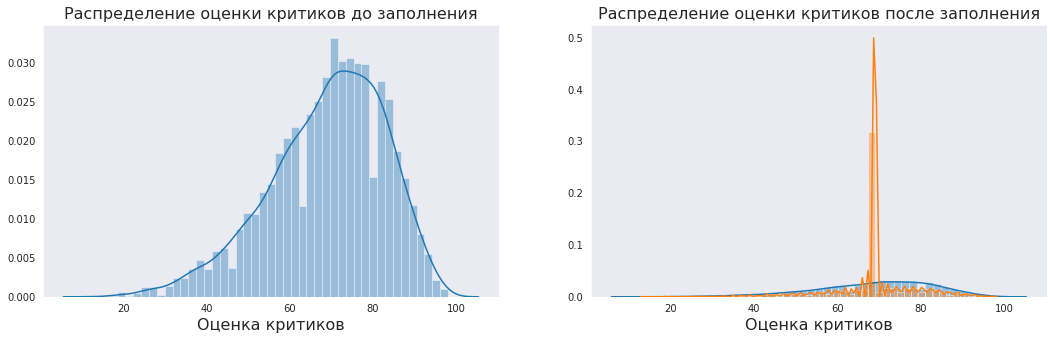

In [15]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(121)
ax1 = sns.distplot(df.critic_score[df.critic_score.notnull()])
ax1.set_xlabel('Оценка критиков', fontdict={'fontsize': 16})
ax1.set_title('Распределение оценки критиков до заполнения', fontdict={'fontsize': 16})
ax2 = plt.subplot(122)
ax2 = sns.distplot(df.critic_score[df.critic_score.notnull()])
ax2 = sns.distplot(df.critic_score.fillna(df.critic_score.mean()))
ax2.set_xlabel('Оценка критиков', fontdict={'fontsize': 16})
ax2.set_title('Распределение оценки критиков после заполнения', fontdict={'fontsize': 16});

Посчитаем сумму выручки по всем регионам.

In [16]:
df = df.assign(total_sales = df.na_sales + df.eu_sales + df.jp_sales + df.other_sales)

# Исследовательский анализ данных

## Количество релизов в год

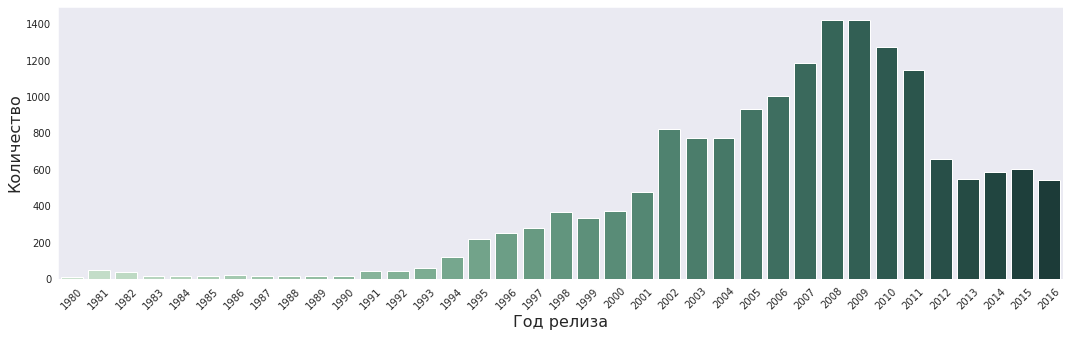

In [17]:
temp = (df
        .pivot_table(index='year_of_release', values='name', aggfunc='count')
        .reset_index())
temp.year_of_release = temp.year_of_release.astype('int')
plt.figure(figsize=(18, 5))
ax = sns.barplot(data=temp, x='year_of_release', y='name', palette="ch:2.5,-.2,dark=.2")
ax.set_xlabel('Год релиза', fontdict={'fontsize': 16})
ax.set_ylabel('Количество', fontdict={'fontsize': 16})
plt.xticks(rotation=45);

На графике видно, что существенный рост выпускаемых игр начался с 1995 года и достиг пика в 2008 и 2009 годах. После этого количество выпускаемых игр пошло на спад, возможно это связано с кризисом 2008 года. Т.к. цикл разработки игр составляет несколько лет, последствия кризиса 2008 года особенно сказались на количестве выпускаемых с 2012 года игр. Для анализа и предсказаний лучше всего будет использовать именно этот период.

## Жизненный цикл платформ

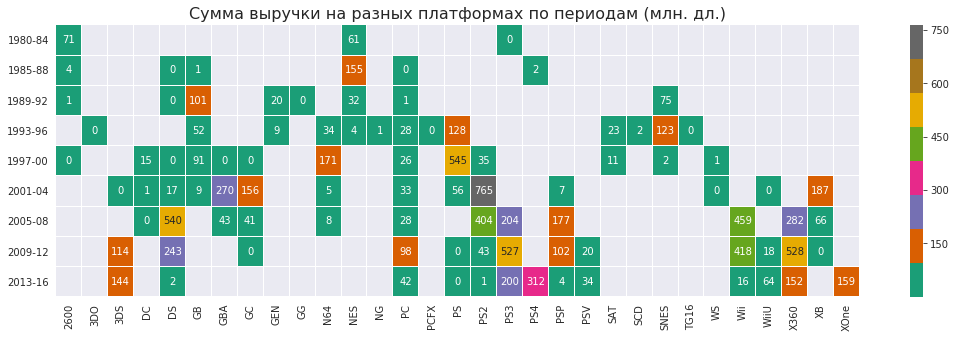

In [18]:
year_interval = pd.interval_range(start=1980, end=2016, freq=4)
temp = (df
        .assign(period = pd.cut(df.year_of_release, year_interval))
        .pivot_table(columns='platform', values='total_sales', aggfunc='sum', index='period'))
temp = temp.dropna(how='all')
plt.figure(figsize=(18,5))
ax = sns.heatmap(temp, linewidths=.009, cmap="Dark2", annot=True, fmt=".0f")
ax.set_title('Сумма выручки на разных платформах по периодам (млн. дл.)', fontdict={'fontsize': 16})
ax.set_xlabel('')
ax.set_yticklabels(['1980-84', '1985-88', '1989-92', '1993-96', '1997-00', '2001-04', '2005-08', '2009-12', '2013-16'])
ax.set_ylabel('');

На этом графике можно определить откровенно неудачные платформы: 3DO, GG, PCFX, SCD, TG16, WS. Эти платформы не смогли пережить четырехлетие своего рождения. У платформ вышедших до 2005 года первая четырехлетка не отличается высокими продажами. Если платформа стала поплярной, то идет существенный рост продаж, например: NES, GB, N64, SNES. После производители изменили подход и начали выпускать большое количество игр вместе со стартом платформы, и если консоль оказывалась удачной продажи росли дальше, например: PS3, 3DS, X360. Видно, что такое поведение производителей стало нормой после PS. Из всей этой картины выбивается PC. Это особенность данной платформы, которая не меняет название и не имеет поколений в отличие от консолей. Нет смысла учитывать консоли на которые не выходят игры, поэтому учитывая предидущий график проанализируем данные с 2012 года.

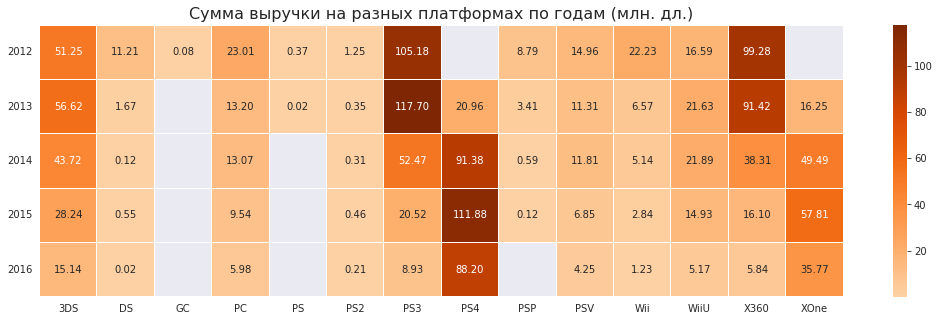

In [19]:
temp = df.query('year_of_release > 2011 and total_sales > 0')
temp = temp.assign(year_of_release = temp.year_of_release.astype('int'))
plt.figure(figsize=(18,5))
ax = sns.heatmap(temp
             .pivot_table(columns='platform', values='total_sales', aggfunc='sum', index='year_of_release'),
            linewidths=.009, cmap="Oranges", annot=True, fmt=".2f", center=40)
ax.set_title('Сумма выручки на разных платформах по годам (млн. дл.)', fontdict={'fontsize': 16})
plt.yticks(va='center', rotation=360)
ax.set_xlabel('')
ax.set_ylabel('');

На графике за 2012-2016 отлично видно как рынок сократился до нескольких производителей. И здесь представлены консоли разных поколений. Выручка плавно перетекает от старой версии к более новой. Данные за 2016 год неполные, поэтому цифры меньше чем за 2015 год. Очевидными тяжеловесами являются: 3DS, PS4, WiiU и XOne. PC гейминг переживает не лучшие времена. Посмотрим как распределены продажи по всем консолям.

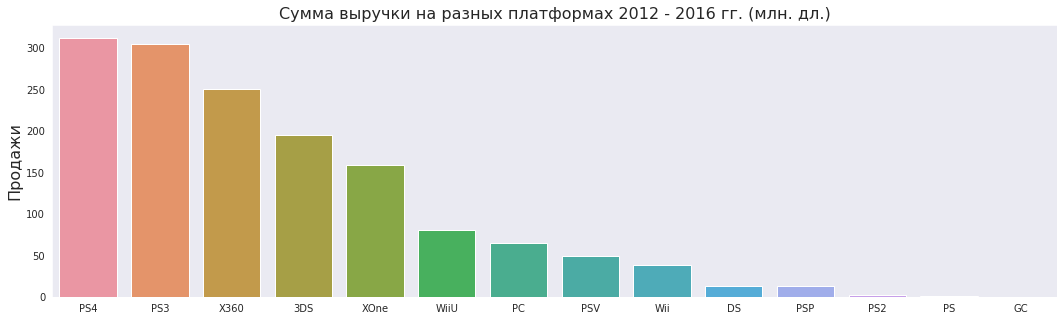

In [20]:
plt.figure(figsize=(18,5))
ax = sns.barplot(data=temp
            .pivot_table(index='platform', values='total_sales', aggfunc='sum')
            .reset_index()
            .sort_values(by='total_sales', ascending=False),
           x='platform', y='total_sales')
ax.set_title('Сумма выручки на разных платформах 2012 - 2016 гг. (млн. дл.)', fontdict={'fontsize': 16})
ax.set_xlabel('')
ax.set_ylabel('Продажи', fontdict={'fontsize': 16});

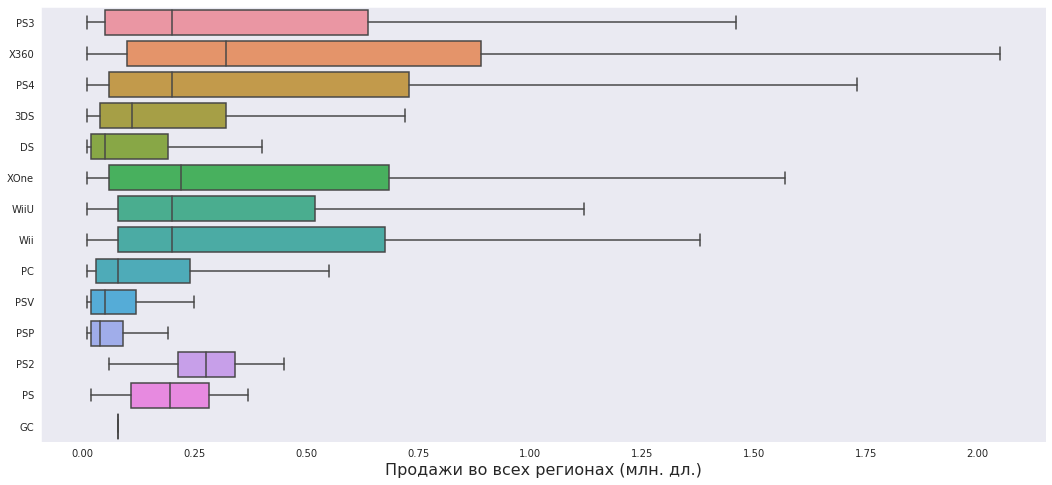

In [21]:
plt.figure(figsize=(18,8))
ax = sns.boxplot(data=temp, y='platform', x='total_sales', showfliers=False)
ax.set_xlabel('Продажи во всех регионах (млн. дл.)', fontdict={'fontsize': 16})
ax.set_ylabel('');

Самые слабые продажи у мобильных консолей от Sony: PSP и PSV. На одном с ними уровне DS, который отдал пальму первенства более новой 3DS. Самая высокая медиана продаж у X360. PS3 и PS4 находятся на одном уровне. По всей видимости слишком мало времени прошло с релиза PS4. Похожая картинка у X360 и XOne. 

Нижняя граница продаж у всех около нуля по очевидным причинам. Но вот чем больше верхняя граница тем больше игр с высокими продажами было у платформы. Так самыми успешными являются <b>X360</b> и <b>PS4</b>, имея в активе больше бестселлеров чем другие платформы.

## Анализ данных по платформам

Выберем для анализа следующие плафтормы: WiiU, PS4, XOne и PC.

In [22]:
def platform_analyse(temp, platform):
    solo_platform = temp.query('platform == @platform')[['critic_score', 'user_score', 'total_sales']]
    plt.figure(figsize=(18,8))
    mask = np.zeros_like(solo_platform.corr())
    mask[np.triu_indices_from(mask)] = True
    ax1 = plt.subplot(221)
    sns.heatmap(solo_platform.corr(), mask=mask, vmax=.3, annot=True, cmap="Dark2", linewidths=.05)
    plt.yticks(va='center')
    ax2 = plt.subplot(222)
    sns.scatterplot(data=solo_platform, x='critic_score', y='total_sales')
    ax2.set_xlabel('Оценка критиков', fontdict={'fontsize': 12})
    ax2.set_ylabel('Продажи во всех регионах', fontdict={'fontsize': 12})
    ax3 = plt.subplot(224)
    sns.scatterplot(data=solo_platform, x='user_score', y='total_sales', color='#A66E00')
    ax3.set_xlabel('Оценка игроков', fontdict={'fontsize': 12})
    ax3.set_ylabel('Продажи во всех регионах', fontdict={'fontsize': 12})
    ax4 = plt.subplot(223)
    sns.distplot(solo_platform.critic_score[solo_platform.critic_score.notnull()]/10)
    sns.distplot(solo_platform.user_score[solo_platform.user_score.notnull()])
    ax4.set_xlabel('Оценка', fontdict={'fontsize': 12})
    ax4.set_ylabel('')
    ax4.legend(['оценка критиков', 'оценка игроков'])
    #sns.boxplot(data=solo_platform, x='total_sales', showfliers=False)

### WiiU

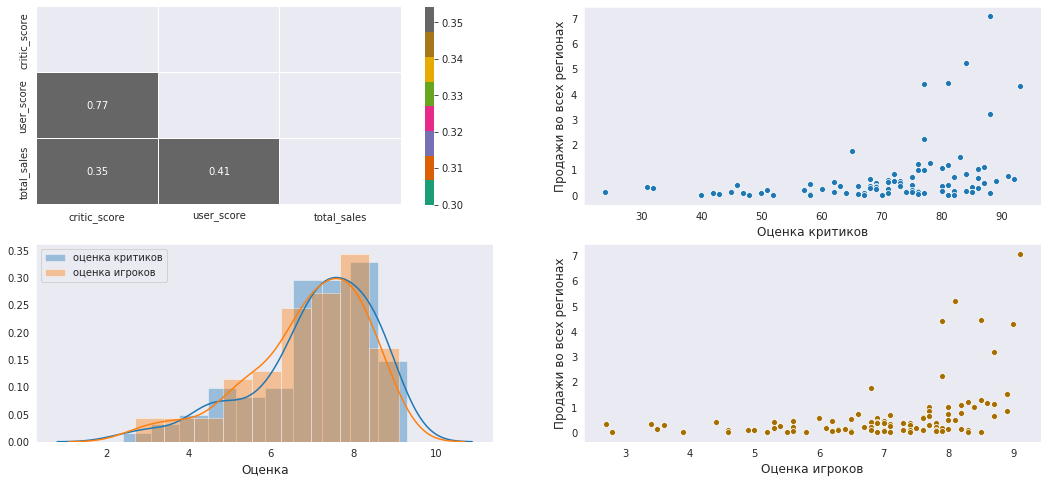

In [23]:
platform_analyse(temp, 'WiiU')

В оценке игр критики и игроки сходятся, коэффициент корреляции <b>0.77</b>. Но это не очень сильно влияет на продажи, коэффициент корреляции <b>0.35</b> и <b>0.4</b> соответственно. Видно что оценки распределены походим образои и большинство колеблется от 7 до 8. На диаграмах рассеивания именно в этом диапазоне распределено большинство игр. Но очевидно, что среди игра с оценками от 8 до 10 есть безусловные бестселлеры с огромным количеством продаж. 

### PlayStation 4

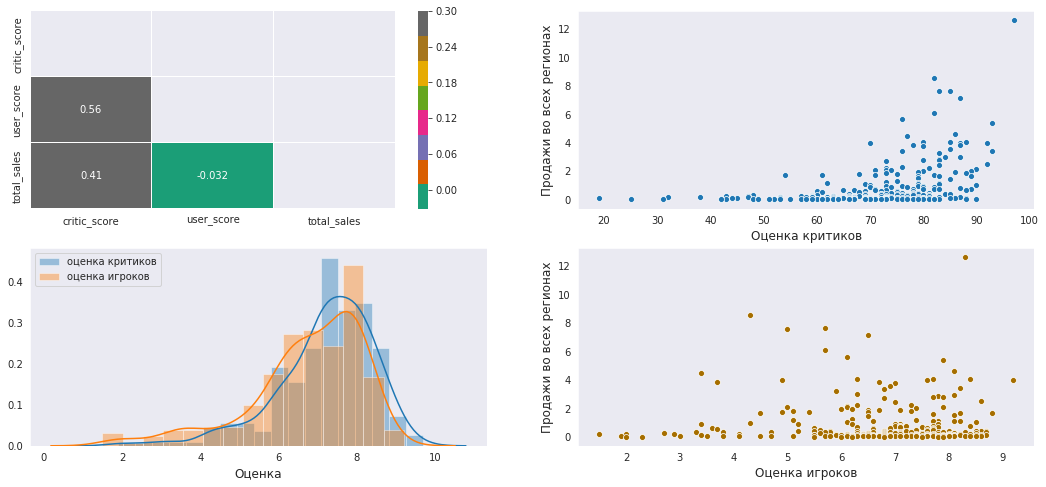

In [24]:
platform_analyse(temp, 'PS4')

В играх для PS4 критики и игроки не так единодушны, коэффициент корреляции всего <b>0.56</b>. На гистограмме видно, что игроки менее довольны играми на PS4. На диаграмах рассеивания видно, что оценки критиков лучше предсказывают продажи, нежели оценки игроков. Это видно и по коэффициенту корреляции: <b>0.41</b> и <b>0</b> соотвественно. Можно сделать вывод, что на этой платформе больше игроков с разными вкусами.

### Xbox One

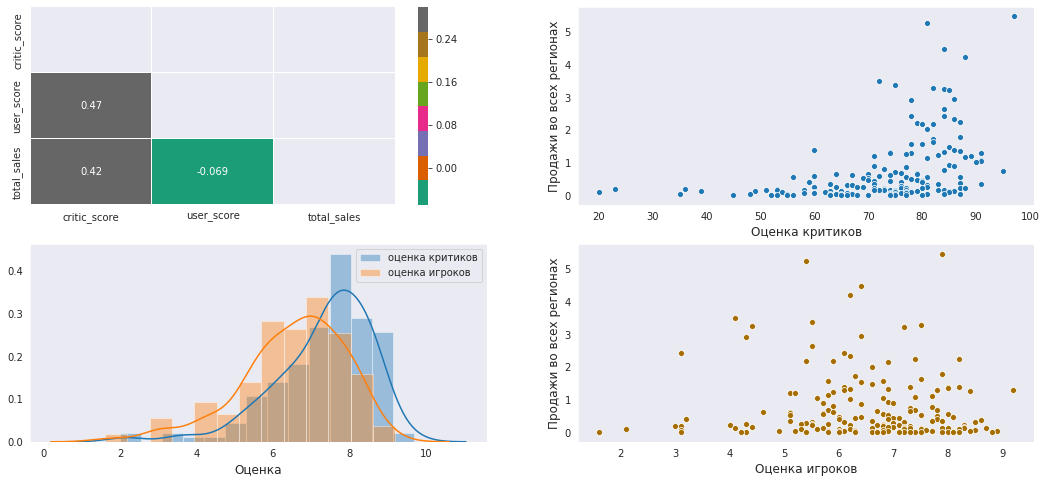

In [25]:
platform_analyse(temp, 'XOne')

На XOne ситуация аналогична PS4. Я думаю такие различия с WiiU обусловлены большим количеством пользователей по всему миру.

### PC

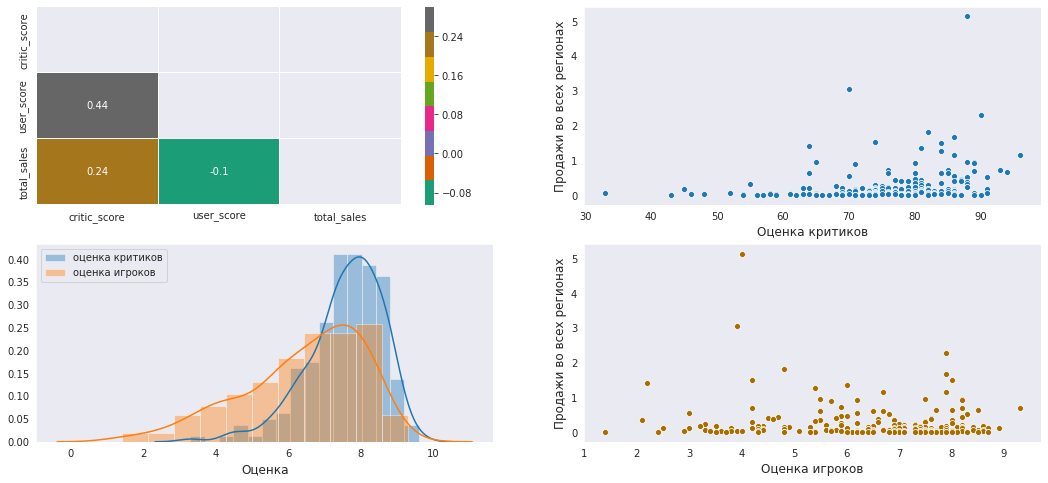

In [26]:
platform_analyse(temp, 'PC')

PC повторяет картину популярных консолей. 

Думаю что оценки критиков больше коррелируют с продажами так как критики получают игру раньше и формируют мнение у неопределившихся игроков о покупке. Критики также претендуют на некоторую "объективность" исключая личные предпочтения, тогда как игроки ставят оценки только исходя из ощущений. И главное, что игроков гораздо больше, поэтому полярность мнений гораздо шире, нежели у критиков. Об этом говорят и гистограммы распредления оценок. 

## Распределение продаж по жанрам

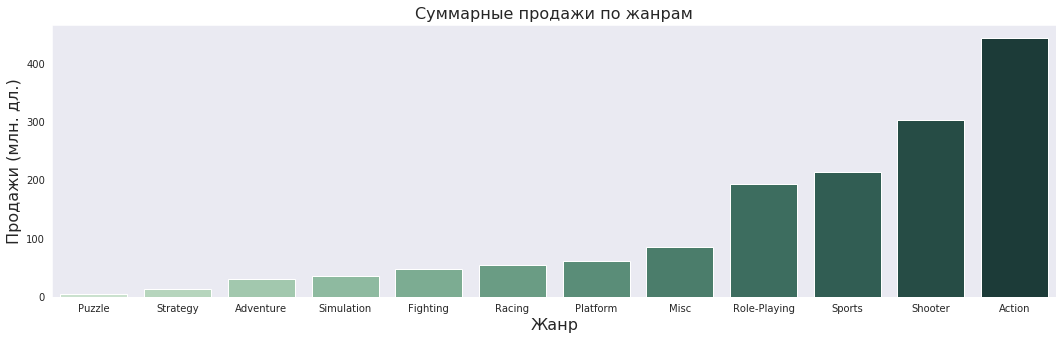

In [27]:
plt.figure(figsize=(18,5))
ax = sns.barplot(data=temp
            .pivot_table(index='genre', values='total_sales', aggfunc='sum')
            .reset_index()
            .sort_values(by='total_sales'),
            x='genre', y='total_sales', palette="ch:2.5,-.2,dark=.2")
ax.set_title('Суммарные продажи по жанрам', fontdict={'fontsize': 16})
ax.set_xlabel('Жанр', fontdict={'fontsize': 16})
ax.set_ylabel('Продажи (млн. дл.)', fontdict={'fontsize': 16});

Самыми популярными жанрами оказались Action-игры и шутеры. А вот стратегии и пазлы в меньшинстве. Стратегии это PC жанр, и таких игр очень мало, соотвественно и продажи низкие. А пазлы подходят для мобильных телефонов.

# Анализ по регионам

## Топ платформ по регионам

In [28]:
def by_region(temp, index):
    plt.figure(figsize=(18,8))
    ax1 = plt.subplot(221)
    sns.barplot(data=temp
            .pivot_table(index=index, values='na_sales', aggfunc='sum')
            .sort_values(by='na_sales', ascending=False)
            .reset_index()
            .head(5),
            x=index, y='na_sales', palette="ch:2.5,-.2,dark=.2")
    ax1.set_xlabel('')
    ax1.set_ylabel('Продажи в Северной Америке', fontdict={'fontsize': 12})
    ax2 = plt.subplot(222)
    sns.barplot(data=temp
            .pivot_table(index=index, values='eu_sales', aggfunc='sum')
            .sort_values(by='eu_sales', ascending=False)
            .reset_index()
            .head(5),
            x=index, y='eu_sales', palette="ch:3,-.2,dark=.2")
    ax2.set_xlabel('')
    ax2.set_ylabel('Продажи в Европе', fontdict={'fontsize': 12})
    ax3 = plt.subplot(223)
    sns.barplot(data=temp
            .pivot_table(index=index, values='jp_sales', aggfunc='sum')
            .sort_values(by='jp_sales', ascending=False)
            .reset_index()
            .head(5),
            x=index, y='jp_sales', palette="ch:3.5,-.2,dark=.2")
    ax3.set_xlabel('')
    ax3.set_ylabel('Продажи в Японии', fontdict={'fontsize': 12})
    ax4 = plt.subplot(224)
    sns.barplot(data=temp
            .pivot_table(index=index, values='other_sales', aggfunc='sum')
            .sort_values(by='other_sales', ascending=False)
            .reset_index()
            .head(5),
            x=index, y='other_sales', palette="ch:4.5,-.2,dark=.2")
    ax4.set_xlabel('')
    ax4.set_ylabel('Продажи в других регионах', fontdict={'fontsize': 12})

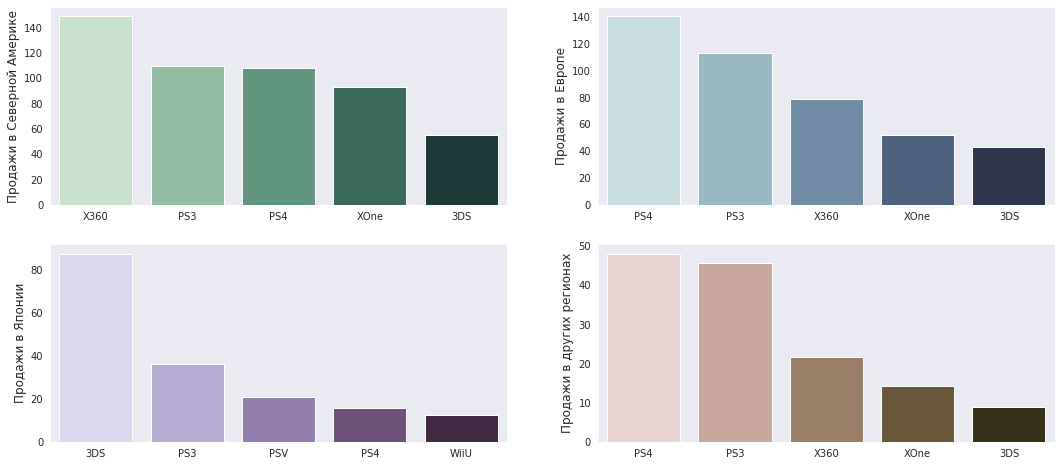

In [29]:
by_region(temp, 'platform')

Япония и Америка патриотичны в своем выборе. Япония больше всего любит 3DS от Nintendo, а в Америке популярна X360 от Microsoft. В Европе люди предпочитают Sony. Хотя топ во всех странах содержит одинаковые консоли. Лидеры рынка явно прослеживаются.

## Топ жанров по регионам

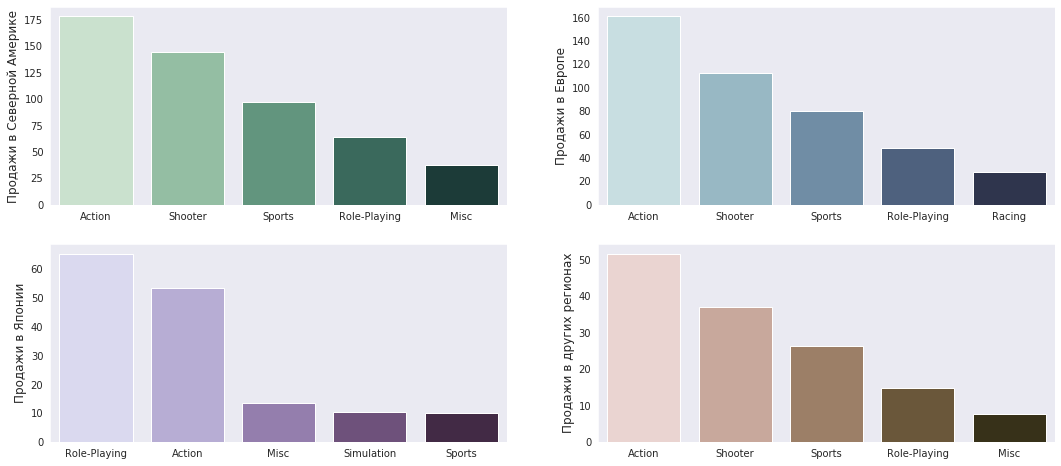

In [30]:
by_region(temp, 'genre')

В жанровой любви больше сходятся Америка и Европа. Предпочитая экшн и шутеры. В Японии на первом месте РПГ. Я связываю это с большим количеством игр жанра j-RPG. В большинстве случаев они выходят только на внутренний рынок и очень популярны. Интересно, что среди топовых жанров Японии нет шутеров. Этот жанр предполагает большую часть игрового процесса в он-лайне. Видимо любовь японцев к изоляции проявляется и в нелюбви к этому жанру.

## Зависимость продаж от жанра в различных регионах

Учтем игры без рейтинга. Пропущенные значения заполним N/A (not available).

In [31]:
temp = temp.fillna(value={'rating':'N/A'})

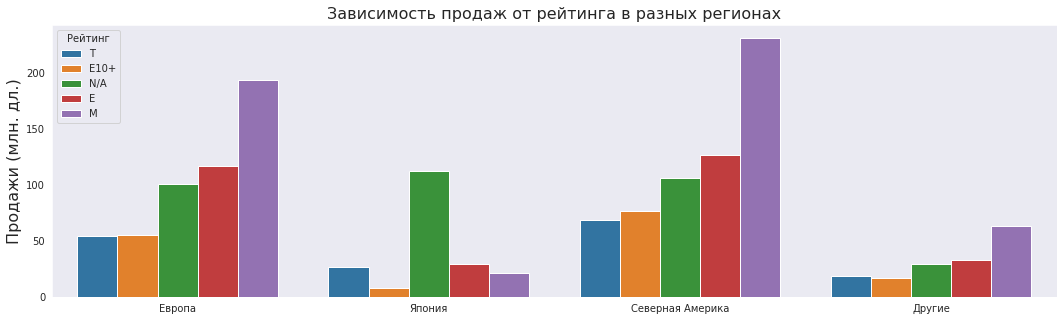

In [32]:
plt.figure(figsize=(18,5))
ax = sns.barplot(data=temp
            .pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum').T
            .reset_index()
            .melt(id_vars=["index"])
            .sort_values(['index', 'value']), 
            hue='rating', y='value', x='index', palette='tab10')
ax.set_title('Зависимость продаж от рейтинга в разных регионах', fontdict={'fontsize': 16})
ax.legend(loc='upper left', title='Рейтинг')
ax.set_xlabel('')
ax.set_xticklabels(['Европа', 'Япония', 'Северная Америка', 'Другие'])
ax.set_ylabel('Продажи (млн. дл.)', fontdict={'fontsize': 16});

А вот среди рейтингов практически полное единодушие. Ретинги <b>М</b> и <b>Е</b> обеспечивают хорошие продажи в Америке и Европе. А вот у Японцев все жанры примерно на одном уровне. Особенно много игр без рейтинга в Японии. По всей видимости там законодательно не обязывают давать рейтинг игре.

# Проверка гипотез

Установим порог статистической значимости за 5%. Данные реальные и случайно получить такое отклонение будет достаточно сложно.

In [33]:
alpha = .05

## PC vs. XboxOne

Нулевая гипотеза: средняя оценка игр пользователями на PC и XboxOne равны.

In [34]:
temp1 = temp.query('platform == "PC"').dropna().user_score
temp2 = temp.query('platform == "XOne"').dropna().user_score

In [35]:
results = st.ttest_ind(temp1, temp2)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5758303162643965
Не получилось отвергнуть нулевую гипотезу


При проведении теста нам не удалось отвергнуть нулевую гипотезу. Делаем вывод что в среднем рейтинге игр различий нет.

## Action vs. Sports

Нулевая гипотеза: средняя оценка игр пользователями жанров Action и Sports равны.

In [36]:
temp1 = temp.query('genre == "Action"').dropna().user_score
temp2 = temp.query('genre == "Sports"').dropna().user_score

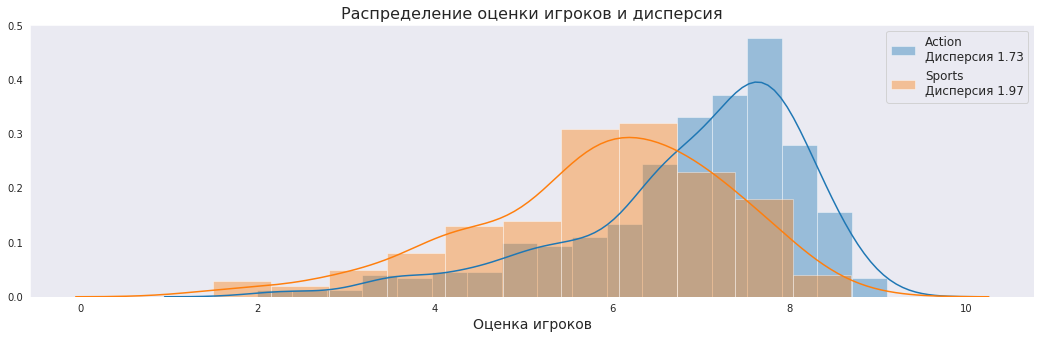

In [37]:
temp1_var = np.var(temp1, ddof=1)
temp2_var = np.var(temp2, ddof=1)
temp1_legend = 'Action\nДисперсия {:.2f}'.format(temp1_var)
temp2_legend = 'Sports\nДисперсия {:.2f}'.format(temp2_var)
temp1 = temp1[temp1.notnull()]
temp2 = temp2[temp2.notnull()]
plt.figure(figsize=(18, 5))
sns.distplot(temp1, label=temp1_legend)
ax = sns.distplot(temp2, label=temp2_legend)
plt.xlabel('Оценка игроков', fontsize=14)
ax.set_title('Распределение оценки игроков и дисперсия', fontdict={'fontsize': 16})
plt.legend(fontsize='large')
plt.show()

Дисперсии выборок примерно равны, значит можем указывать параметр equal_var=True

In [39]:
results = st.ttest_ind(temp1, temp2, equal_var=True)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.469765849576292e-15
Отвергаем нулевую гипотезу


При проведение теста не получилось подтвердить нулевую гипотезу. Делаем вывод, что средние рейтинги игр жанров Action и Sports отличаются.

# Вывод

После анализа можно спрогнозировать продажи на 2017 год. Стратегии в разных регионах будут немного отличаться.<br>
<b>Северная Америка</b>:
- Консоли: PS4, XboxOne и Xbox360. XboxOne вышла недавно, но стремительно набирает продажи, с каждым годом они только росли, и не смотря на то, что в пока продажи ниже чем у X360, будущее за новым поколением.
- Жанры: Action и Shooter
- Рейтинг: M и E

<br><b>Европа</b>:
- Консоли: PS4, PS3 и XboxOne. Консоли от сони абсолютные фавориты. Но можно будет что-то заработать и на отночительно новой консоли от Микрософт.
- Жанры: Action и Shooter
- Рейтинг: M и E

<br><b>Япония</b>:
- Консоли: 3DS, PS3, PS4
- Жанры: RPG и Action
- Ретинг для Японии не является существенным фактором.
Все продажи коррелируют с оценкой критиков. Этот фактор безусловно не самый определяющий, но влияние он имеет. Поэтому сосредоточиться можно на играх которые хвалят.